In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
from starfish import data
import torch.tensor as T
import pprint

In [28]:
from decode_fish.funcs.merfish_eval2 import *
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))
img = load_tiff_from_list(image_paths)

bench_df, code_ref, targets = get_benchmark()

13832


# MERFISH with DECODE

## 17.08.2021

# Dataset

* The data analyzed was recorded for _High-throughput single-cell gene-expression profiling with multiplexed error-robust fluorescence in situ hybridization_ (Moffitt et.  al. 2016)
* A small subset of this data, including the original analysis results is available through the Starfish python library.
* The data from one field of view correspond to 16 images from 8 hybridzation rounds 2 color channels one z plane. Each image is 2048x2048 (y,x).
* The data show U2OS cells in culture

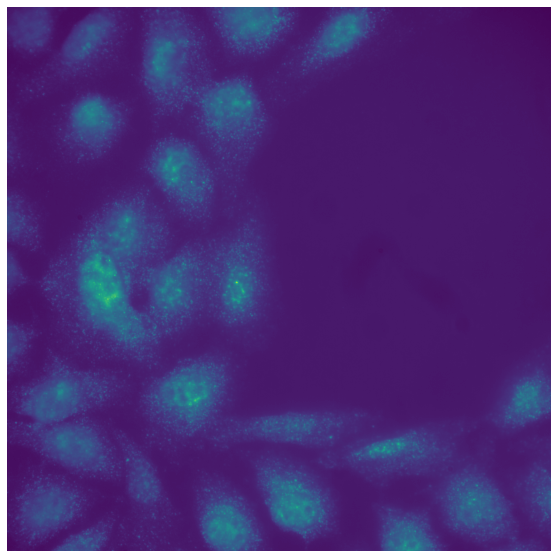

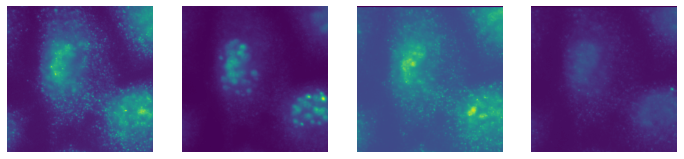

In [25]:
plt.figure(figsize=(10,10))
plt.imshow(img[0,0])
plt.axis('off')

sl = np.s_[:500,400:900]

plt.figure(figsize=(12,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(img[i,0][sl])
    plt.axis('off')

# The Codebook

* The MERFISH codebook maps 140 16-bit barcodes to different genes. 
* 10 out of 140 targets are _Blanks_. Codes that are generated the same way but don't map to other genes. They can be used to estimate error rates.
* Each code has 4 on-bits. Therefore 140 out of 1820 possible codes are occupied. 
* The codebook is designed to be error robust, i.e. each code has a high distance to all others


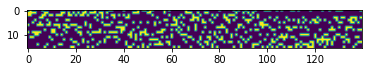

In [38]:
_ = plt.imshow(code_ref.T)

# DECODING methods

* The initial MERFISH science paper (Chen et al. Science 2015) performs independent localization (DAOSTORM, Backcock et. al) and then groups localizations across channel based on their distance.
* The reference analysis for the dataset used does not rely on localizations, instead:
    1. All channels are deconvolved using a Gaussian filter.
    2. Each pixel is matched to a code from the codebook based on the normalized intensities across channels. 
    3. Adjacent pixels matched to the same code are grouped.
    4. The candidates are filtered using the area (>3 pixels) and the 'total magnitude', i.e. the overall intensity


    
* Three recent methods perform nonnegative deconvolution with an observation model that includes the codebook:
    1. Chen et al. _BARcode DEmixing through Non-negative Spatial Regression (BarDensr)_, 2021, Paninski Lab
    2. Anderson et al. _ISTDECO: In Situ Transcriptomics Decoding by Deconvolution_, 2021
    3. Bryan et al. SPARSE RECOVERY OF IMAGING TRANSCRIPTOMICS DATA. 2021
* ISTDECO compares to BARDENSR (similar performance) and shows result on the Starfish/MERFISH dataset

# My approach

I started by performing localization for individual channels (with context) and then grouping them using various algorithms. 
This worked but gave subpar results.

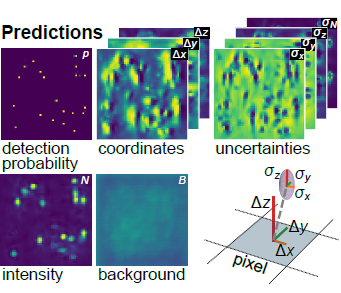